# Task 2 : Building the baseline model

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
import keras_tuner as kt

from funcs_Task1 import training_data_Pipeline, test_validation_data_Pipeline, test_data_Pipeline_non_normalized
from funcs_Task3 import plot_accuracy_loss, concat_generators, plot_confusion_matrix

In [2]:
# constants
img_height = img_width = 128
batch_size = 128
img_size = (img_height, img_width)

train_dir = 'covid xray/train'
val_dir = 'covid xray/val'
test_dir = 'covid xray/test'

epochs = 30

### 1. Set up the classification

In [3]:

# Set random seeds for reproducibility
np.random.seed(123)  
tf.random.set_seed(123) 

# evaluation metrics
METRICS = ["accuracy"]

### 2. Build initial model


In [4]:
# Step 2: Build Initial Model

model = models.Sequential()

# Convolutional Part
model.add(layers.Input(shape=(128, 128, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))  # First conv layer
model.add(layers.MaxPooling2D(2, 2))                          # Pooling
model.add(layers.BatchNormalization())                        # Normalization
model.add(layers.Conv2D(64, (3, 3), activation='relu'))      # Second conv layer
model.add(layers.MaxPooling2D(2, 2))                          # Pooling

# Fully Connected Part
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))          # Dense layer
model.add(layers.Dropout(0.5))                                # Dropout layer

# Output layer
model.add(layers.Dense(1, activation='sigmoid'))             # Binary classification

# Compile model
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=METRICS)


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,049 (14.14 MB)

 Trainable params: 3,705,985 (14.14 MB)

 Non-trainable params: 64 (256.00 B)

### 3. Train your model

In [ ]:
# Use existing data pipelines
train_data_gen = training_data_Pipeline(batch_size, img_size, train_dir)
val_data_gen = test_validation_data_Pipeline(batch_size, img_size, test_dir=val_dir, train_dir=train_dir)

# Get sample counts (if not already defined)
total_train = train_data_gen.samples
total_val = val_data_gen.samples

# Compile the model (keep your existing METRICS)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
   metrics=METRICS
)

# Train the model
history = model.fit(
    train_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)


Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


c:\Users\friev\OneDrive - UGent\MaStat\Big Data Science\Artificial Intelligence\exercises\project\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.5823 - loss: 1.4804 - val_accuracy: 0.5234 - val_loss: 0.6876
Epoch 2/30
 1/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7344 - loss: 0.5904

c:\Users\friev\OneDrive - UGent\MaStat\Big Data Science\Artificial Intelligence\exercises\project\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 251ms/step - accuracy: 0.7344 - loss: 0.5904 - val_accuracy: 0.6224 - val_loss: 0.6799
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.5991 - loss: 0.6981 - val_accuracy: 0.5026 - val_loss: 0.7053
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 271ms/step - accuracy: 0.5938 - loss: 0.5904 - val_accuracy: 0.5078 - val_loss: 0.7012
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.6503 - loss: 0.5863 - val_accuracy: 0.5000 - val_loss: 0.9432
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 378ms/step - accuracy: 0.6953 - loss: 0.5555 - val_accuracy: 0.5078 - val_loss: 0.9380
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.6693 - loss: 0.5460 - val_accuracy: 0.5469 - val_loss: 0.6851
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 288ms/step - accuracy: 0.6875 - loss: 0.5637 - val_accuracy: 0.5573 - val_loss: 0.6744
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.6722 - loss: 0.5532 - val_accuracy: 0.5547 - val_loss: 0.

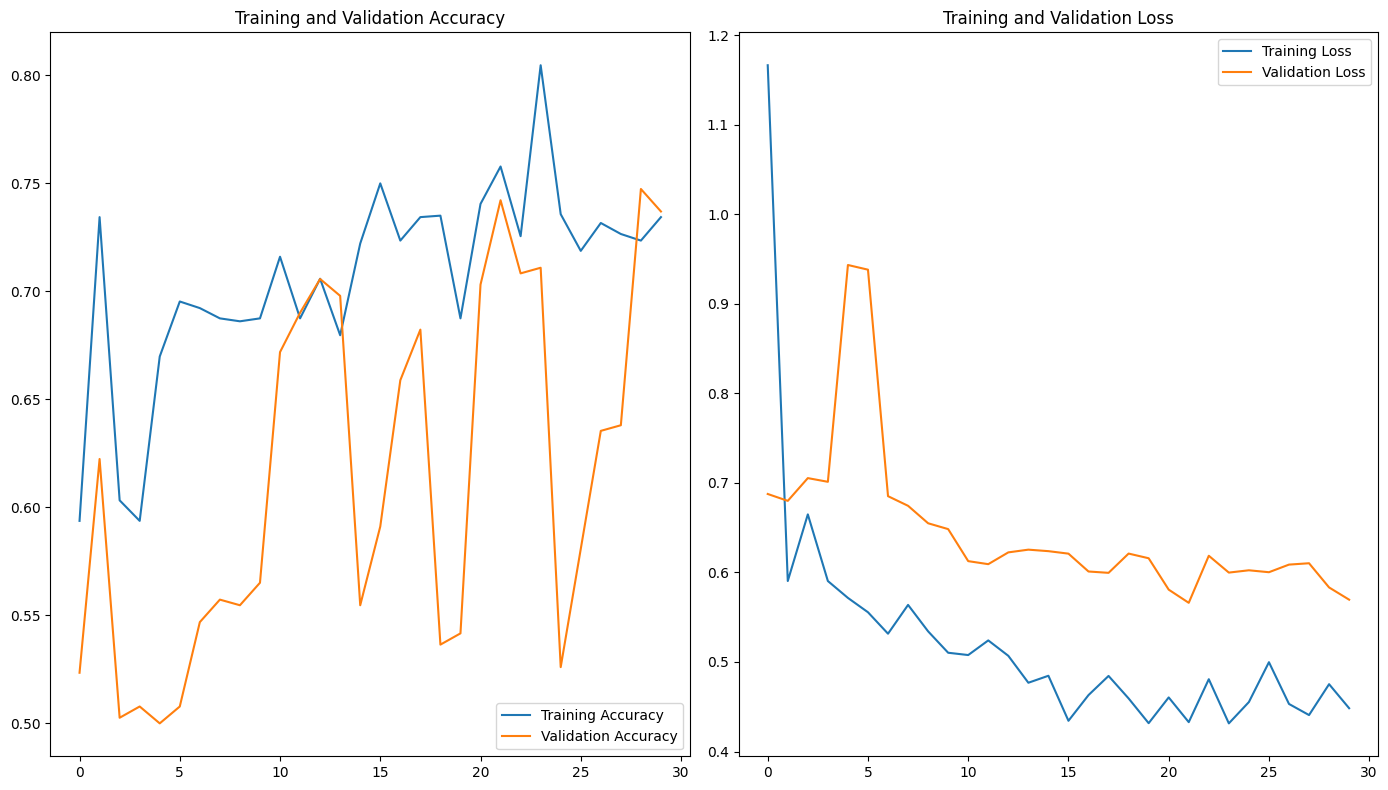

In [6]:
plot_accuracy_loss(history, epochs)

### 4. Hyperparameter tuning

In [7]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [8]:


def build_model(hp):

    # Tune number of filters
    filters = hp.Choice('filters', [32, 64])

    # Tune dropout rate
    dropout_rate = hp.Choice('dropout_rate', [0.3, 0.2])

    # Tune learning rate
    learning_rate = hp.Choice('learning_rate', [1e-3, 1e-4])

    # Tune optimizer
    optimizer_choice = hp.Choice('optimizer', ['adam', 'sgd'])

    new_model = models.Sequential()

    # Convolutional Part
    new_model.add(layers.Input(shape=(128, 128, 3)))
    new_model.add(layers.Conv2D(filters, (3, 3), activation='relu'))
    new_model.add(layers.MaxPooling2D(2, 2))
    new_model.add(layers.BatchNormalization())
    new_model.add(layers.Conv2D(filters, (3, 3), activation='relu'))
    new_model.add(layers.MaxPooling2D(2, 2))

    # Fully Connected Part
    new_model.add(layers.Flatten())
    new_model.add(layers.Dense(64, activation='relu'))
    new_model.add(layers.Dropout(dropout_rate))

    # Output layer
    new_model.add(layers.Dense(1, activation='sigmoid'))

    # Compile with chosen optimizer and learning rate
    if optimizer_choice == 'adam':
        optimizer = optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = optimizers.SGD(learning_rate=learning_rate)

    new_model.compile(optimizer=optimizer,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

    return new_model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='kt_dir_task2',
    project_name='cnn_tuning_task2'
)

tuner.search(
    train_data_gen,
    epochs=5,
    validation_data=val_data_gen,
    steps_per_epoch=total_train // batch_size,
    validation_steps=total_val // batch_size,
    callbacks=[early_stop]
)


Reloading Tuner from kt_dir_task2\cnn_tuning_task2\tuner0.json


In [11]:
best_hp = tuner.get_best_hyperparameters(1)[0]

print("Best filter count:", best_hp.get('filters'))
print("Best dropout rate:", best_hp.get('dropout_rate'))
print("Best learning rate:", best_hp.get('learning_rate'))
print("Best optimizer:", best_hp.get('optimizer'))

best_val_acc = tuner.get_best_models(1)[0].evaluate(val_data_gen, verbose=0)[1]

results = []
results.append({
        'batch_size': batch_size,
        'learning_rate': best_hp.get('learning_rate'),
        'dropout_rate': best_hp.get('dropout_rate'),
        'val_accuracy': best_val_acc
    })

df = pd.DataFrame(results)
df.to_csv("hyperparameter_tuning_task2.csv", index=False)

Best filter count: 64
Best dropout rate: 0.3
Best learning rate: 0.0001
Best optimizer: adam


c:\Users\friev\OneDrive - UGent\MaStat\Big Data Science\Artificial Intelligence\exercises\project\venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### 5. final baseline

In [ ]:
training_data_gen = training_data_Pipeline(128, img_size, train_dir)
val_data_gen = test_validation_data_Pipeline(128, img_size, train_dir, val_dir)
full_data_gen = concat_generators(training_data_gen, val_data_gen)

learning_rate = 0.001
dropout_rate = 0.3
filters = 32
optimizer = 'sgd'

final_model = models.Sequential()

# Convolutional Part
final_model.add(layers.Input(shape=(128, 128, 3)))
final_model.add(layers.Conv2D(filters, (3, 3), activation='relu'))  # First conv layer
final_model.add(layers.MaxPooling2D(2, 2))                          # Pooling
final_model.add(layers.BatchNormalization())                        # Normalization
final_model.add(layers.Conv2D(filters, (3, 3), activation='relu'))      # Second conv layer
final_model.add(layers.MaxPooling2D(2, 2))                          # Pooling

# Fully Connected Part
final_model.add(layers.Flatten())
final_model.add(layers.Dense(64, activation='relu'))          # Dense layer
final_model.add(layers.Dropout(dropout_rate))                                # Dropout layer

# Output layer
final_model.add(layers.Dense(1, activation='sigmoid'))             # Binary classification

optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
final_model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=METRICS)

history = model.fit(
    full_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7459 - loss: 0.4475

c:\Users\friev\OneDrive - UGent\MaStat\Big Data Science\Artificial Intelligence\exercises\project\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.7448 - loss: 0.4479 - val_accuracy: 0.7448 - val_loss: 0.5758
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.7320 - loss: 0.4615 - val_accuracy: 0.7370 - val_loss: 0.5919
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7434 - loss: 0.4633 - val_accuracy: 0.7552 - val_loss: 0.5675
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7550 - loss: 0.4611 - val_accuracy: 0.7448 - val_loss: 0.5866
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.7039 - loss: 0.4781 - val_accuracy: 0.6328 - val_loss: 0.5830
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7282 - loss: 0.4516 - val_accuracy: 0.7630 - val_loss: 0.5293
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.7416 - loss: 0.4408 - val_accuracy: 0.7474 - val_loss: 0.5368
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.7681 - loss: 0.4294 - val_accuracy: 0.6354 - val_loss: 0.5875
Epo

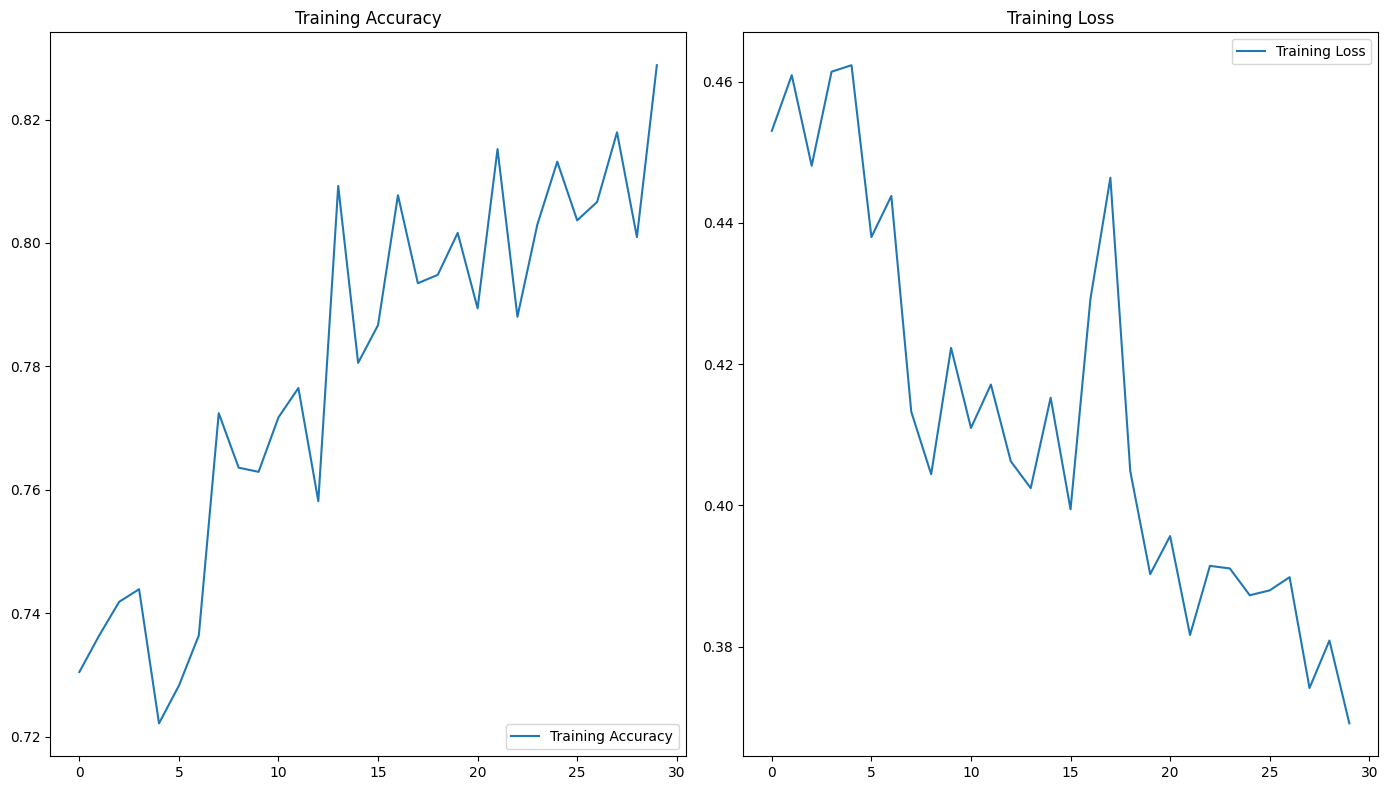

In [13]:
plot_accuracy_loss(history, epochs, validation = False)

In [ ]:
# Save the model to disk and load it back
final_model.save('covid_xray_model.keras')  # Save the model
loaded_model = tf.keras.models.load_model('covid_xray_model.keras')  # Load the model

# model evaluation, print performance metrics
test_data_gen = test_validation_data_Pipeline(batch_size, img_size, train_dir, test_dir)
loss, accuracy = loaded_model.evaluate(test_data_gen)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Found 1600 images belonging to 2 classes.


c:\Users\friev\OneDrive - UGent\MaStat\Big Data Science\Artificial Intelligence\exercises\project\venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Found 200 images belonging to 2 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 404ms/step - accuracy: 0.4792 - loss: 0.9348
Test Loss: 0.9049
Test Accuracy: 0.5000


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 512ms/step


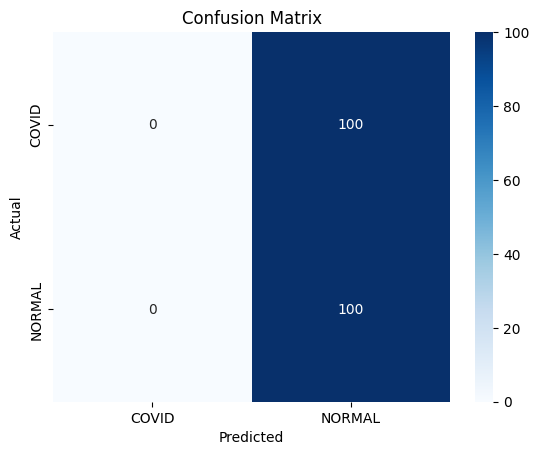

In [15]:
# confusion matrix
y_true = test_data_gen.classes
y_pred_probs = final_model.predict(test_data_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

plot_confusion_matrix(y_true, y_pred, test_data_gen)

Found 1600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 391ms/step
Found 200 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0051578176..8.137312].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0054494417..7.987884].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003950409..7.3735414].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0042246496..8.502952].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0040637827..8.880075].


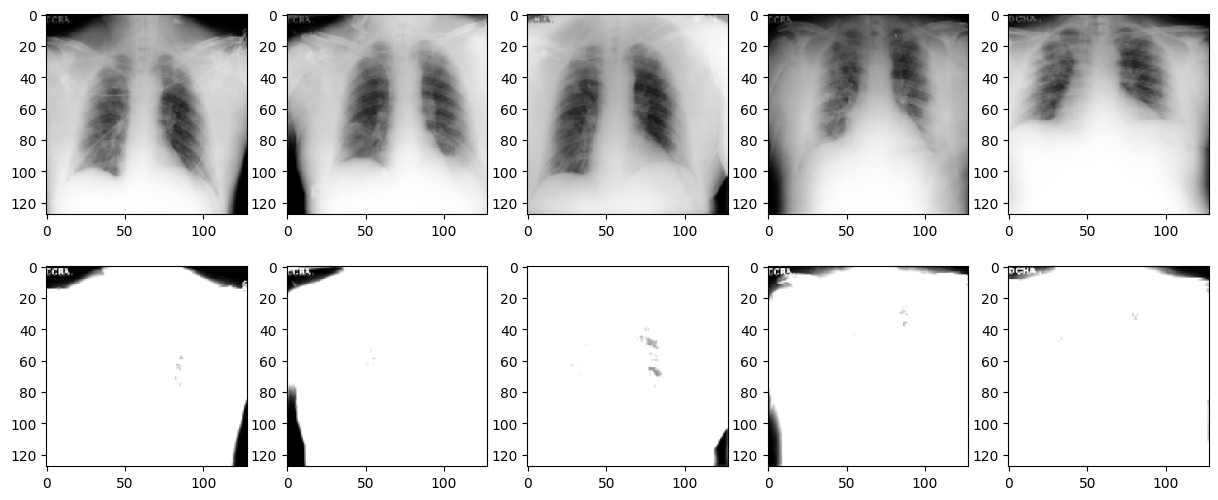

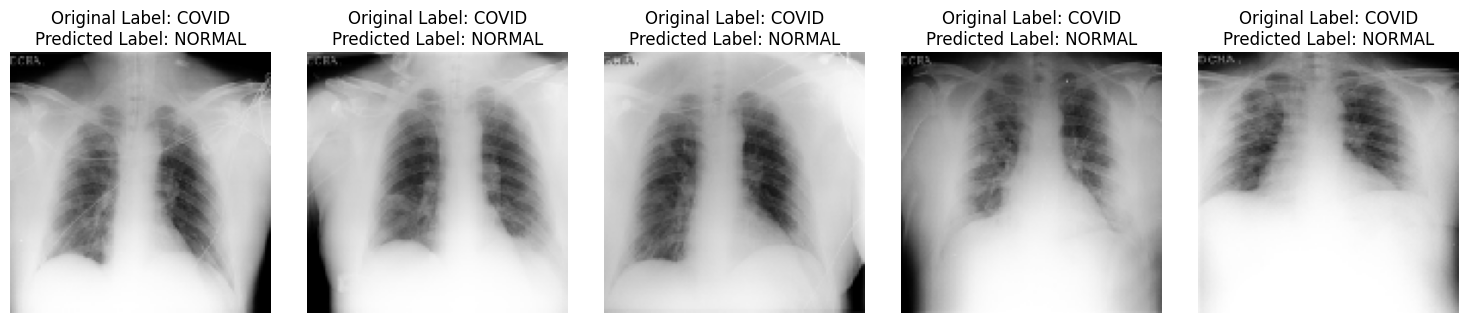

In [ ]:
# Plot a few samples from the test dataset without normalization with evaluation (after normalization)

# Get batch and process
## normalized 
test_data_gen_normalized  = test_validation_data_Pipeline(batch_size, img_size, train_dir, test_dir, shuffle = False)
y_pred_probs = final_model.predict(test_data_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
sample_images_normalized, sample_labels_normalized  = next(test_data_gen_normalized)

## non-normalized 
test_data_gen_non_normalized = test_data_Pipeline_non_normalized(batch_size, img_size, test_dir)
sample_images_non_normalized, sample_labels_non_normalized =  next(test_data_gen_non_normalized)

class_names = list(test_data_gen.class_indices.keys())

plt.figure(figsize=(15, 6))
for i, (img, label, pred) in enumerate(zip(sample_images_non_normalized[:5], sample_labels_non_normalized[:5], y_pred[:5])):
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original Label: {class_names[int(label)]}\nPredicted Label: {class_names[pred]}"), plt.axis('off')
    
plt.tight_layout()
plt.show()